# DCGAN for CIFAR10 image generation
#### Original Paper (DCGAN): https://arxiv.org/pdf/1511.06434
#### Implementation by Zach D.

## Defining the network

In [1]:
import tensorflow as tf
from IPython.display import clear_output, Image
tf.enable_eager_execution()

Slight modification made to GAN architecture to make network work with 32x32 images instead of 64x64 like in the original paper.

Create the generator and discriminator networks

In [2]:
def create_generator():
    dropout_prob = .4

    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(8*8*256, input_shape=(100,)))
    net.add(tf.keras.layers.Reshape(target_shape=(8, 8, 256)))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 8x8
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 16x16
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 32x32
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 64x64
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.Activation('sigmoid')) # size = 128x128
    
    return net

In [3]:
def create_discriminator():
    dropout_prob = .4
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', input_shape=(128, 128, 3)))
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 64x64
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', strides=(2, 2)))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 32x32
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 16x16
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.LeakyReLU(0.2)) # size = 8x8
    net.add(tf.keras.layers.Dropout(dropout_prob))
    
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(1))
    net.add(tf.keras.layers.Activation('sigmoid'))
    
    return net

Create a trainable discriminator, as well as the full GAN architecture with the discriminator frozen.

In [4]:
d_net = create_discriminator()
g_net = create_generator()

d_model = tf.keras.Sequential([d_net])
d_optim = tf.keras.optimizers.Adam(lr=0.000008, decay=1e-10)
d_model.compile(optimizer=d_optim, loss='binary_crossentropy', metrics=['accuracy'])

for layer in d_net.layers:
    layer.trainable = False
    
gan_model = tf.keras.Sequential([g_net, d_net])
gan_optim = tf.keras.optimizers.Adam(lr=0.00004, decay=1e-10)
gan_model.compile(optimizer=gan_optim, loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Load data

In [5]:
from glob import glob
import random
import matplotlib.pyplot as plt
batch_size = 128

In [6]:
filepaths = list(glob("E:/data/faces/gt_db/gt_db/*/*.jpg"))

def preprocess_fn(filepath):
    x = tf.read_file(filepath)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize_images(x, size=(128,128))
    x = tf.reshape(tf.cast(x, tf.float32), (128,128,3))
    x /= 255
    return x

real_ds = tf.data.Dataset.from_tensor_slices(filepaths)
real_ds = real_ds.shuffle(10000)
real_ds = real_ds.repeat()
real_ds = real_ds.apply(tf.data.experimental.map_and_batch(
        preprocess_fn, batch_size, num_parallel_batches=6, drop_remainder=True))
real_ds = real_ds.prefetch(tf.data.experimental.AUTOTUNE)

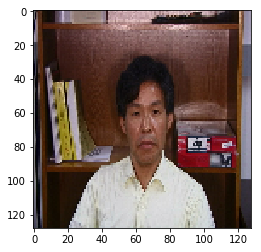

In [7]:
real_iter = real_ds.make_one_shot_iterator()
real_batch = real_iter.get_next()
rand_n = random.randint(0,batch_size-1)
plt.figure()
plt.imshow(real_batch[rand_n])

## Train network

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os

In [9]:
loss_gan = []
loss_dis = []
acc_gan = []
acc_dis = []
plot_iteration = []

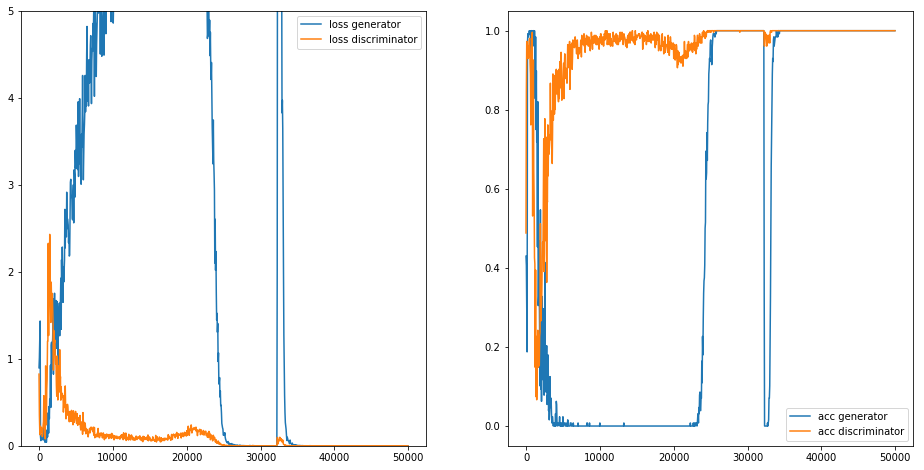

In [10]:
dtime = datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(dtime)
os.mkdir(dtime + "/imgs")
os.mkdir(dtime + "/weights")

real_iter = real_ds.make_one_shot_iterator()  

for i in range(0,50000):
    # Grab a batch of real data
    real_batch = real_iter.get_next()
    # Make a batch of fake data by feeding the generator some noise and taking its output
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    fake_batch = g_net.predict(noise, batch_size=batch_size)

    # Create the labels for each set of data (0 for fake, 1 for real)
    real_labels = np.ones([batch_size])
    fake_labels = np.zeros([batch_size])
    # Train discriminator on real and fake data
    d_fake_stats = d_model.train_on_batch(fake_batch, fake_labels)
    d_real_stats = d_model.train_on_batch(real_batch, real_labels)
        
    d_loss_avg = (d_real_stats[0] + d_fake_stats[0])/2
    d_acc_avg = (d_real_stats[1] + d_fake_stats[1])/2
    
    # Train the generator on noise
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    y = np.ones([batch_size])
    g_stats = gan_model.train_on_batch(noise, y)
    
    # Train the generator again (test)
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
    g_stats = gan_model.train_on_batch(noise, y)
    
    # Save weights and save generator output
    if i % 200 == 0:
        #sample image
        rand_n = random.randint(0,batch_size-1)
        plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
        plt.axis('off')
        plt.imshow(fake_batch[rand_n])
        plt.savefig(f"{dtime}/imgs/epoch_{i*batch_size//60000}_step_{i}.png")
        plt.close()
        #save weights
        d_net.save(f"{dtime}/weights/d_net_{i}.h5")
        g_net.save(f'{dtime}/weights/g_net_{i}.h5')

    if i % 50 == 0:
        plot_iteration.append(i)
        loss_gan.append(g_stats[0])
        loss_dis.append(d_loss_avg)
        acc_gan.append(g_stats[1])
        acc_dis.append(d_acc_avg)

        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_gan, label="loss generator")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_gan, label="acc generator")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()

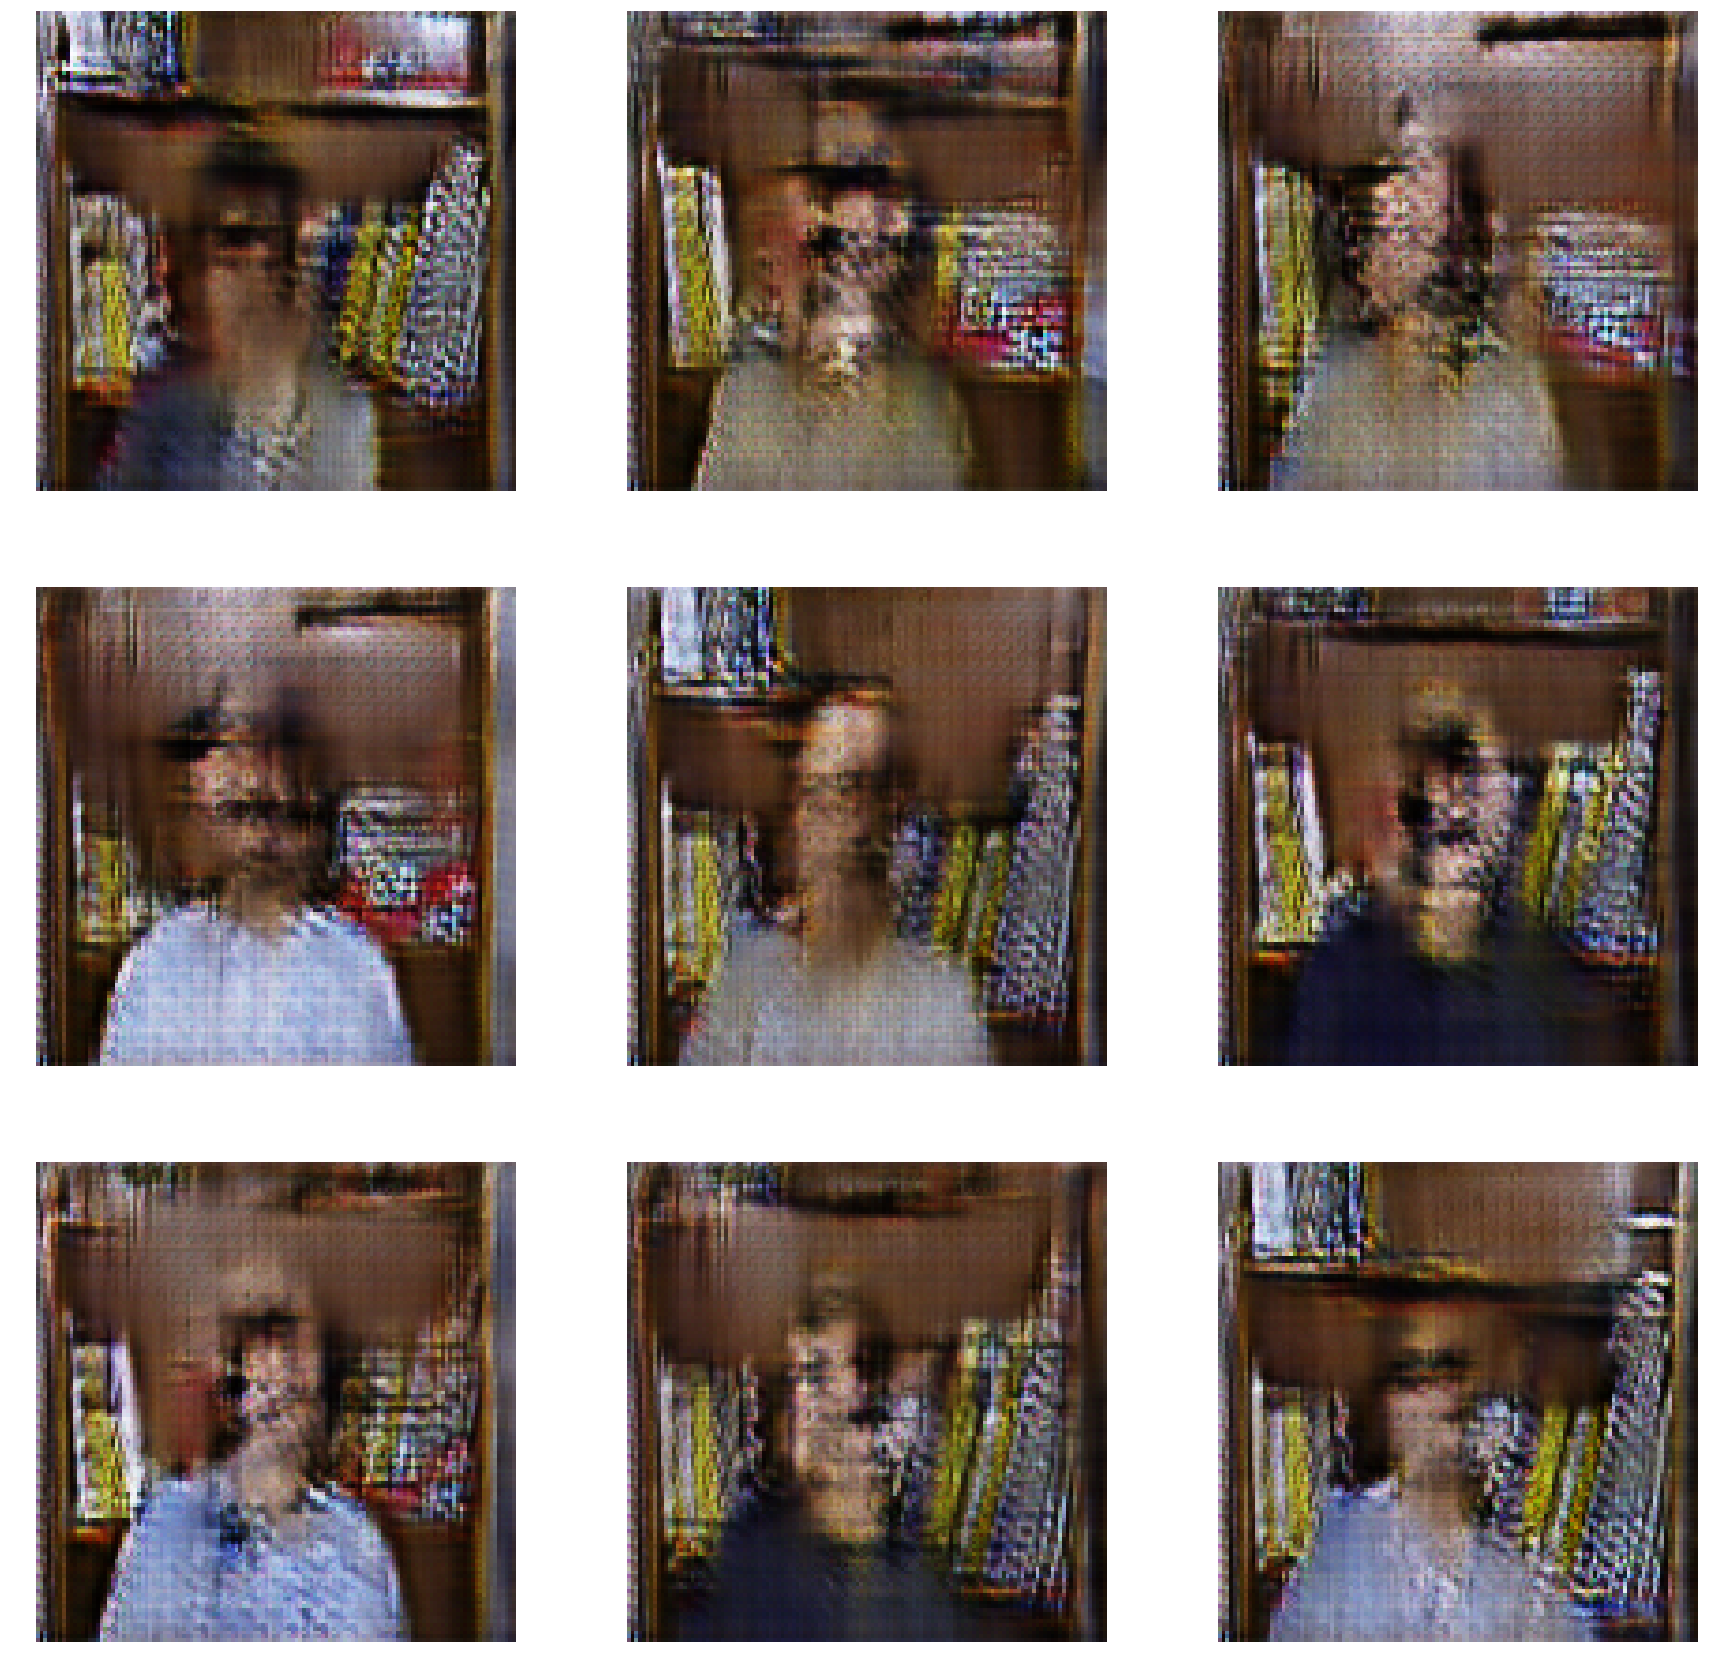

In [16]:
# print some results

noise = np.random.uniform(-1.0, 1.0, size=(batch_size, 100,))
fake_batch = g_net.predict(noise, batch_size=batch_size)

fig = plt.figure(figsize=(30, 30))
for i in range(0, 9):
    rand_n = random.randint(0,batch_size-1)
    plt.axis('off')
    ax1 = fig.add_subplot(3,3,i+1)
    ax1.imshow(fake_batch[rand_n])
plt.axis('off')
plt.savefig(f"results.png", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()